<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

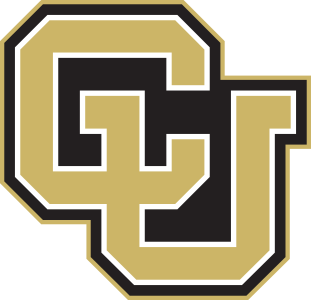

# Lecture 8, hands-on: Applying Ensemble Approaches
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Reading Material

From the scikit-learn documentation:

* [Ensembles in supervised learning](https://scikit-learn.org/stable/modules/ensemble.html) (Random forests, gradient boosting, etc).
* [Cluster ensembles](https://towardsdatascience.com/how-to-ensemble-clustering-algorithms-bf78d7602265) (post on Medium).

# Random forests
(Adapted from [PyCon 2015 scikit-learn tutorial](https://github.com/jakevdp/sklearn_pycon2015) by Jake VanderPlas)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from sklearn.tree import DecisionTreeClassifier

# from sklearn.linear_model import LinearRegression
# from scipy import stats
# import pylab as pl

seaborn.set()

## Auxiliary functions

In [2]:
def plot_example_decision_tree():
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
    ax.set_title("Example Decision Tree: Animal Classification", size=24)

    def text(ax, x, y, t, size=20, **kwargs):
        ax.text(
            x,
            y,
            t,
            ha="center",
            va="center",
            size=size,
            bbox=dict(boxstyle="round", ec="k", fc="w"),
            **kwargs,
        )

    text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
    text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
    text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
    text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
    text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
    text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
    text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

    text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
    text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

    text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

    text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

    ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], "-k")
    ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], "-k")
    ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], "-k")
    ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], "--k")
    ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], "--k")
    ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], "--k")
    ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], "--k")
    ax.axis([0, 1, 0, 1])


def visualize_tree(estimator, X, y, boundaries=True, xlim=None, ylim=None):
    estimator.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap="rainbow")
    plt.clim(y.min(), y.max())

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")
    plt.axis("off")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.clim(y.min(), y.max())

    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_

        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, "-k")
            plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)

        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], "-k")
            plot_boundaries(tree.children_left[i], xlim, [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim, [tree.threshold[i], ylim[1]])

    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())


def plot_tree_interactive(X, y):
    from sklearn.tree import DecisionTreeClassifier

    def interactive_tree(depth=1):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    from ipywidgets import interact

    return interact(interactive_tree, depth=[1, 5])

## Random Forest Classifier

Random forests are an example of an *ensemble learner* built on decision trees.
For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification:

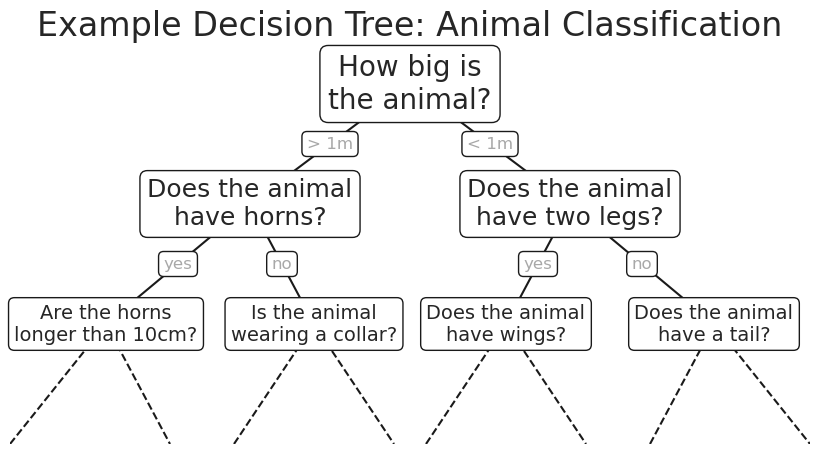

In [3]:
plot_example_decision_tree()

The binary splitting makes this extremely efficient.
As always, though, the trick is to *ask the right questions*.
This is where the algorithmic process comes in: in training a decision tree classifier, the algorithm looks at the features and decides which questions (or "splits") contain the most information.

### Creating a Decision Tree

Here's an example of a decision tree classifier in scikit-learn. We'll start by defining some two-dimensional labeled data:

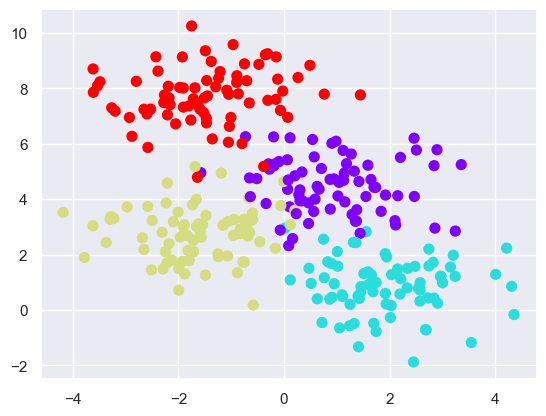

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")

In [ ]:
plot_tree_interactive(X, y)

interactive(children=(Dropdown(description='depth', options=(1, 5), value=1), Output()), _dom_classes=('widget…

<function __main__.plot_tree_interactive.<locals>.interactive_tree(depth=1)>

Notice that at each increase in depth, every node is split in two **except** those nodes which contain only a single class.
The result is a very fast **non-parametric** classification, and can be extremely useful in practice.

**Question:** Do you see any problems with this?

_Answer_: The decision tree could overfit and learn some very strict decision boundaries that perform poorly during testing and cannot be generalized.

### Decision Trees and overfitting

One issue with decision trees is that it is very easy to create trees which **overfit** the data. That is, they are flexible enough that they can learn the structure of the noise in the data rather than the signal! For example, take a look at two trees built on two subsets of this dataset:

<Figure size 640x480 with 0 Axes>

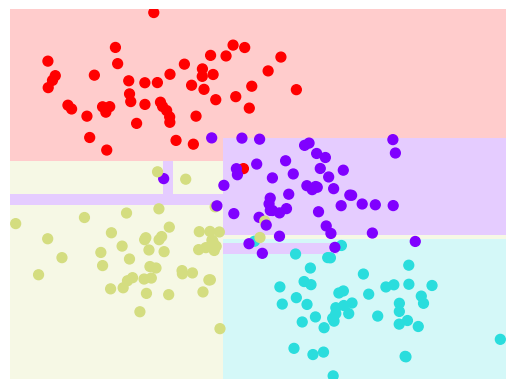

In [5]:
from sklearn.tree import plot_tree

plt.figure()
clf = DecisionTreeClassifier()
visualize_tree(clf, X[:200], y[:200], boundaries=False)

[Text(0.4625, 0.9444444444444444, 'x[1] <= 6.261\nsamples = 200\nvalue = [51, 47, 52, 50]'),
 Text(0.4125, 0.8333333333333334, 'x[0] <= -0.549\nsamples = 154\nvalue = [51, 47, 52, 4]'),
 Text(0.4375, 0.8888888888888888, 'True  '),
 Text(0.15, 0.7222222222222222, 'x[1] <= 4.075\nsamples = 56\nvalue = [3, 0, 50, 3]'),
 Text(0.1, 0.6111111111111112, 'samples = 48\nvalue = [0, 0, 48, 0]'),
 Text(0.2, 0.6111111111111112, 'x[1] <= 5.521\nsamples = 8\nvalue = [3, 0, 2, 3]'),
 Text(0.1, 0.5, 'x[1] <= 4.515\nsamples = 4\nvalue = [2, 0, 2, 0]'),
 Text(0.05, 0.3888888888888889, 'samples = 1\nvalue = [1, 0, 0, 0]'),
 Text(0.15, 0.3888888888888889, 'x[0] <= -1.631\nsamples = 3\nvalue = [1, 0, 2, 0]'),
 Text(0.1, 0.2777777777777778, 'samples = 1\nvalue = [0, 0, 1, 0]'),
 Text(0.2, 0.2777777777777778, 'x[0] <= -1.382\nsamples = 2\nvalue = [1, 0, 1, 0]'),
 Text(0.15, 0.16666666666666666, 'samples = 1\nvalue = [1, 0, 0, 0]'),
 Text(0.25, 0.16666666666666666, 'samples = 1\nvalue = [0, 0, 1, 0]'),
 Text(

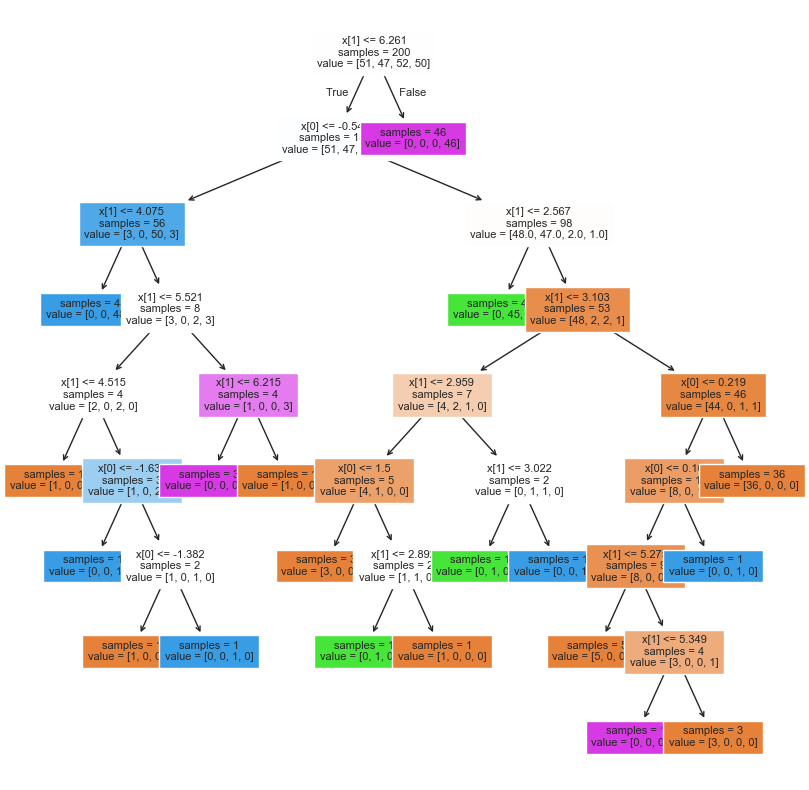

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(clf, impurity=False, filled=True, ax=ax, fontsize=8)

<Figure size 640x480 with 0 Axes>

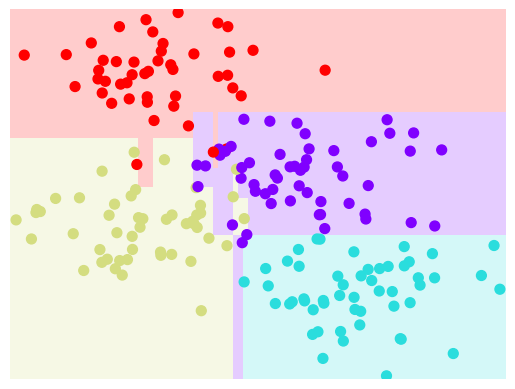

In [8]:
plt.figure()
clf = DecisionTreeClassifier()
visualize_tree(clf, X[-200:], y[-200:], boundaries=False)

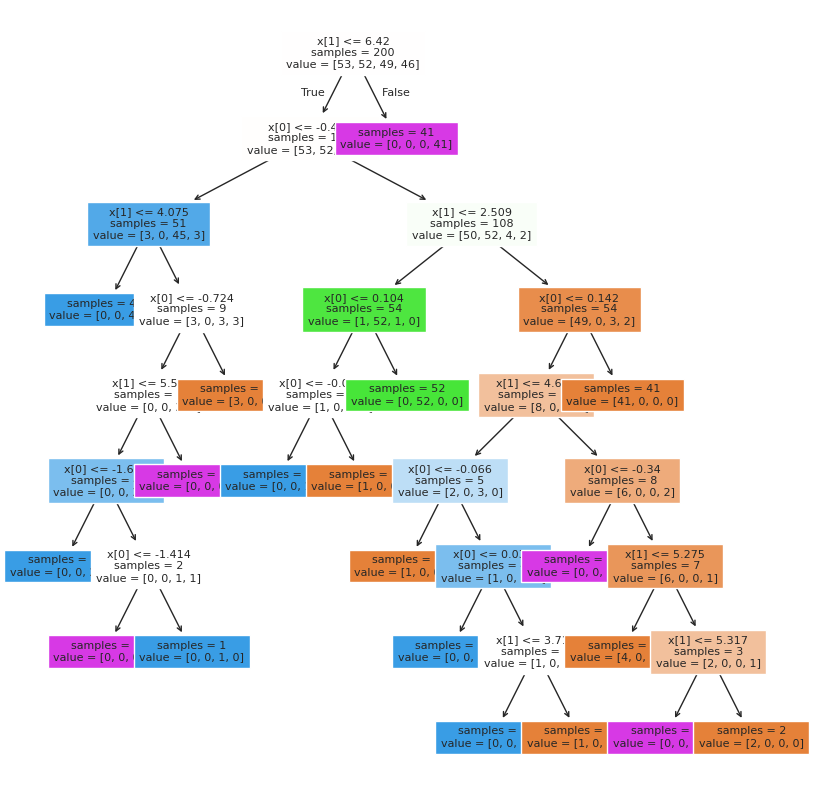

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(clf, impurity=False, filled=True, ax=ax, fontsize=8)

The details of the classifications are completely different! That is an indication of **overfitting**: when you predict the value for a new point, the result is more reflective of the noise in the model rather than the signal.

## Ensembles of Estimators: Random Forests

One possible way to address overfitting is to use an **ensemble method**: this is a meta-estimator which essentially averages the results of many individual estimators which overfit the data. Somewhat surprisingly, the resulting estimates are much more robust and accurate than the individual estimates which make them up!

One of the most common ensemble methods is the **random forest**, in which the ensemble is made up of many decision trees which are in some way perturbed.

There are volumes of theory and precedent about how to randomize these trees, but as an example, let's imagine an ensemble of estimators fit on subsets of the data. We can get an idea of what these might look like as follows:

In [7]:
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)

    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(
        clf,
        X[i[:250]],
        y[i[:250]],
        boundaries=False,
        xlim=(X[:, 0].min(), X[:, 0].max()),
        ylim=(X[:, 1].min(), X[:, 1].max()),
    )


from ipywidgets import interact

interact(fit_randomized_tree, random_state=[0, 100])

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

<function __main__.fit_randomized_tree(random_state=0)>

See how the details of the model change as a function of the sample, while the larger characteristics remain the same!
The random forest classifier will do something similar to this, but use a combined version of all these trees to arrive at a final answer:

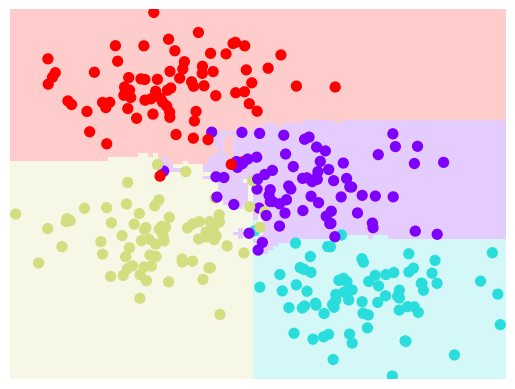

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
visualize_tree(clf, X, y, boundaries=False)

By averaging over 100 randomly perturbed models, we end up with an overall model which is a much better fit to our data!

*(Note: above we randomized the model through sub-sampling... Random Forests use more sophisticated means of randomization, which you can read about in, e.g. the [scikit-learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)*)

## Random Forest Regressor

Above we were considering random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is ``sklearn.ensemble.RandomForestRegressor``.

Let's quickly demonstrate how this can be used:

<ErrorbarContainer object of 3 artists>

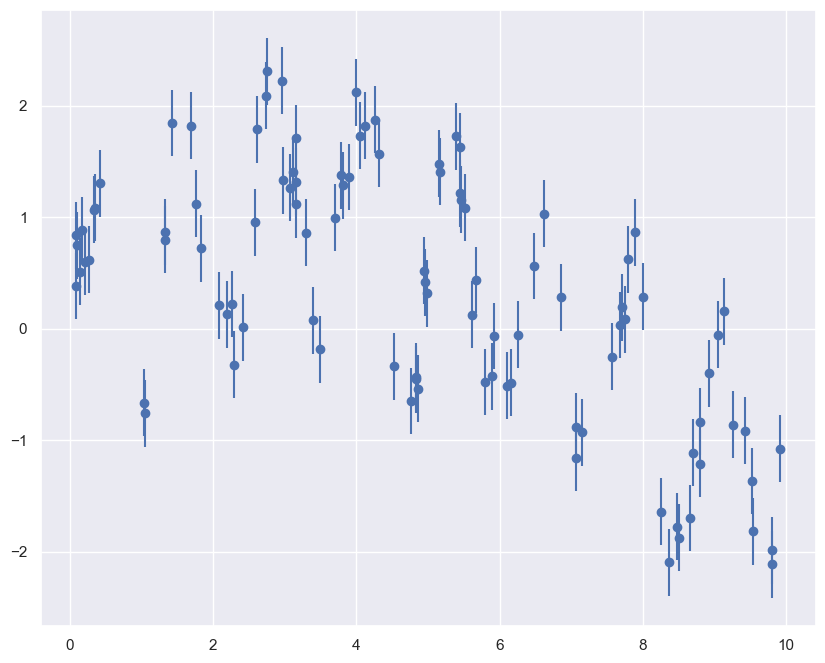

In [9]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)


def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + fast_oscillation + noise


y = model(x)
fig, ax = plt.subplots(figsize=(10, 8))
plt.errorbar(x, y, 0.3, fmt="o")

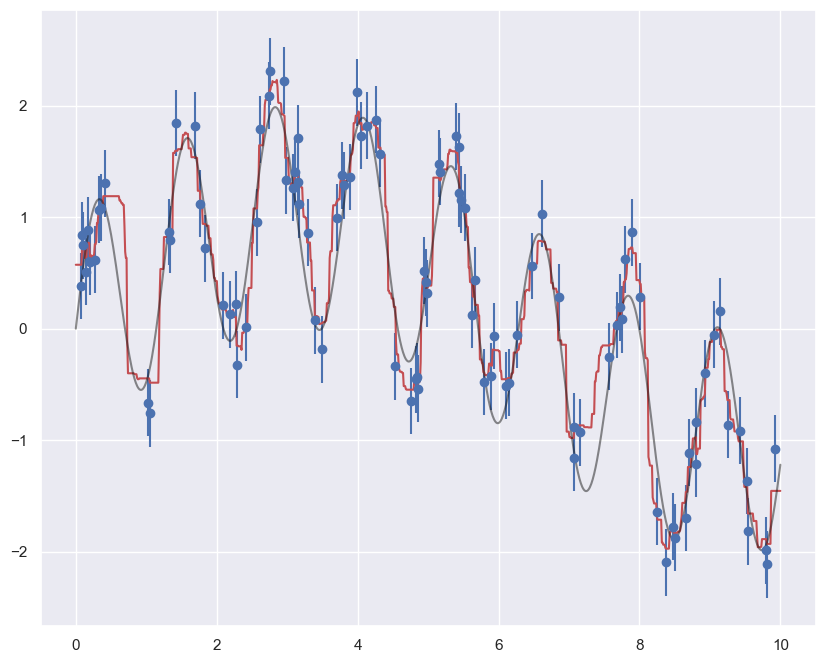

In [10]:
xfit = np.linspace(0, 10, 1000)
yfit = RandomForestRegressor(100).fit(x[:, None], y).predict(xfit[:, None])
ytrue = model(xfit, 0)

fig, ax = plt.subplots(figsize=(10, 8))
plt.errorbar(x, y, 0.3, fmt="o")
plt.plot(xfit, yfit, "-r")
plt.plot(xfit, ytrue, "-k", alpha=0.5)

As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us even specifying a multi-period model!

* Tradeoff between simplicity and thinking about what your data is.
* Feature engineering is important, need to know your domain: Fourier transform frequency distribution.

## Random Forest Limitations

The following data scenarios are not well suited for random forests:
* y: lots of 0, few 1
* Structured data like images where a neural network might be better
* Small data size which might lead to overfitting
* High dimensional data where a linear model might work better

# Exercise 1: AdaBoost

Implement AdaBoost on the following example, and compare with Random Forests.

In [11]:
import numpy as np
from sklearn.datasets import make_gaussian_quantiles

# Construct dataset
X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1
)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

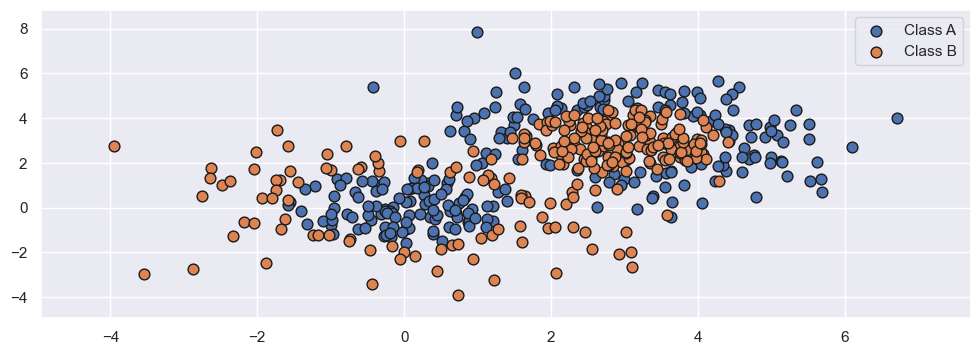

In [12]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 4]

plot_colors, plot_step, class_names = "br", 0.02, "AB"
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0],
        X[idx, 1],
        s=60,
        edgecolor="k",
        label="Class %s" % n,
    )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

# Exercise 2: GradientBoosting

Implement Gradient Boosting on the previous example and compare results.

In [18]:
# add cell